In [219]:
include("hmat.jl")
include("test_Merton_kernel.jl")
include("tools.jl")
using BenchmarkTools
using Polynomials


In [41]:
n = 10
N = 2^n
cs = uniform_cluster(N, 64)
h = 2/(N-1)
X = h*collect(-2^(n-1):2^(n-1)-1)
X = reshape(X, length(X), 1)
c = cluster_from_list(cs, X);

In [178]:
NT = 100
Δt = 1/NT
C = sqrt(π)
f, αs, βs = Merton_Kernel(5.0, 10)
H = construct_hmat_from_expansion(f, αs, βs, c, 64, 2^(n-2))
H1 = copy(H)
H2 = copy(H)


haxpy!(0.5*h, H1, -C/2+1/Δt)
haxpy!(-0.5*h, H2, C/2+1/Δt)

A = kernel_full(f, c.X, c.X)
verify_matrix_error(H, A)
verify_matvec_error(H, A)
A1 = 0.5*h*A+(-C/2+1/Δt)*diagm(0=>ones(size(A,1))) # right
A2 = -0.5*h*A+(C/2+1/Δt)*diagm(0=>ones(size(A,1))) # left 
verify_matrix_error(H1, A1)
verify_matvec_error(H1, A1)
verify_matrix_error(H2, A2)
verify_matvec_error(H2, A2)


Matrix Error = 0.0008371932668557139
Matvec Error = 2.340610656676255e-5
Matrix Error = 8.183707398394074e-7
Matvec Error = 3.48309905956462e-8
Matrix Error = 8.183707398394074e-7
Matvec Error = 3.3479819864426476e-8


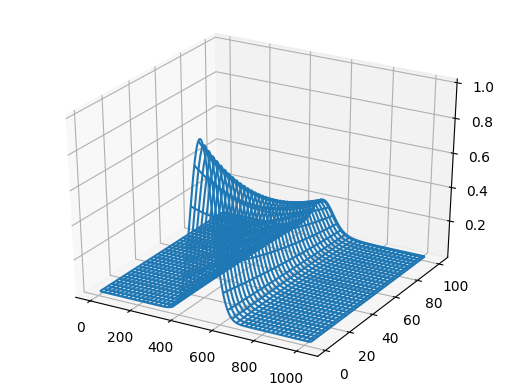

PyObject <mpl_toolkits.mplot3d.art3d.Line3DCollection object at 0x7f788122a7f0>

In [179]:
# iteration
U1 = zeros(size(c.X,1), NT+1)
U1[:,1] = exp.(-50 * c.X.^2)

F = lu(A2)
for i = 1:NT
    U1[:,i+1] = F\(A1*U1[:,i])
end

mesh(U1)

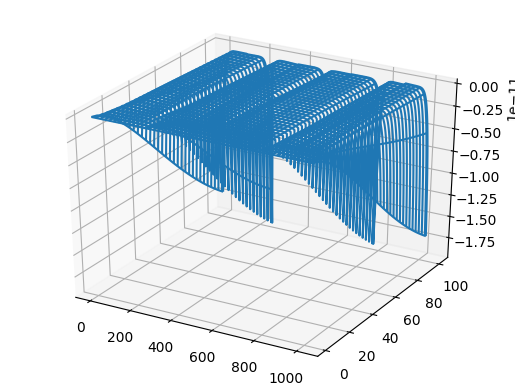

PyObject <mpl_toolkits.mplot3d.art3d.Line3DCollection object at 0x7f78ae0079e8>

In [99]:
# H matrix iteration
U = zeros(size(c.X,1), NT+1)
U[:,1] = exp.(-50 * c.X.^2)

HH = copy(H2)
lu!(HH, 1e-1)
for i = 1:NT
    U[:,i+1] = pygmres(H2, H1*U[:,i], HH)
end

mesh(U-U1)

## Efficiency Test

In [172]:
function benchmark1(n=10)
    N = 2^n
    cs = uniform_cluster(N, 64)
    h = 2/(N-1)
    X = h*collect(-2^(n-1):2^(n-1)-1)
    X = reshape(X, length(X), 1)
    c = cluster_from_list(cs, X);

    NT = 100
    Δt = 1/NT
    C = sqrt(π)
    f, αs, βs = Merton_Kernel(1.0, 10)
    t1 = @timed H = construct_hmat_from_expansion(f, αs, βs, c, 64, 2^(n-2))
    H1 = copy(H)
    H2 = copy(H)


    haxpy!(0.5*h, H1, -C/2+1/Δt)
    haxpy!(-0.5*h, H2, C/2+1/Δt)

    x = rand(N)
    y = rand(N)
    x1 = rand(N)
    t2 = @timed begin
        for i = 1:10
            y = H2*x
        end
    end

    HH = copy(H2)
    GC.enable(false)
    t3 = @timed lu!(HH, 1e-2)
    GC.enable(true)
    GC.gc()

    t4 = @timed begin
        for i = 1:10
            x1 = HH\y
        end
    end
    x2, err2 = pygmres_with_call_back(H2, y, nothing, false)
    x3, err3 = pygmres_with_call_back(H2, y, HH, false)
    println("Error = $(rel_error(x, x1)), Iter = $(length(err2))")
    println("Error = $(rel_error(x, x2)), Iter = $(length(err3))")

    (t1[2], t2[2]/10, t3[2], t4[2]/10), t1[3]
end

benchmark1 (generic function with 2 methods)

In [222]:
benchmark1()
T = []
S = []
for n = 10:20
    t, s = benchmark1(n)
    push!(T, t)
    push!(S, s)
    println(t, s)
end

Error = 3.253318669591758e-8, Iter = 3
Error = 3.0136904797738223e-10, Iter = 2
Error = 1.161970714446236e-8, Iter = 3
Error = 2.7167175830634013e-10, Iter = 2
(0.016117583, 0.0004577314, 0.033150665, 0.0006127878)4716768
Error = 1.0742320155448032e-7, Iter = 3
Error = 8.425295953067576e-11, Iter = 2
(0.046379019, 0.0010067572000000001, 0.089554581, 0.0013368844)11744336
Error = 1.0969963246160389e-7, Iter = 3
Error = 7.111360895657383e-11, Iter = 2
(0.127069826, 0.0021811736, 0.215134275, 0.0032873561000000004)27932048
Error = 1.3666368387868252e-7, Iter = 3
Error = 3.08712592007986e-11, Iter = 2
(0.292432849, 0.0071558649, 0.474807033, 0.0069357575000000005)64503792
Error = 1.4516409931018172e-7, Iter = 3
Error = 5.857748496987444e-11, Iter = 2
(0.860845945, 0.019902382599999997, 1.057615582, 0.020686970800000003)145966480
Error = 1.4836845555671829e-7, Iter = 3
Error = 2.20646665306532e-11, Iter = 2
(2.081860078, 0.043914754, 2.172390986, 0.0408734937)325468368
Error = 1.43773943343

In [161]:
function benchmark2(n=10)
    N = 2^n
    cs = uniform_cluster(N, 64)
    h = 2/(N-1)
    X = h*collect(-2^(n-1):2^(n-1)-1)
    X = reshape(X, length(X), 1)
    c = cluster_from_list(cs, X);

    NT = 100
    Δt = 1/NT
    C = sqrt(π)
    
    f, αs, βs = Merton_Kernel(1.0, 10)
    t1 = @timed A = kernel_full(f, c.X, c.X)
    A1 = 0.5*h*A+(-C/2+1/Δt)*diagm(0=>ones(size(A,1))) # right
    A2 = -0.5*h*A+(C/2+1/Δt)*diagm(0=>ones(size(A,1))) # left 

    x = rand(N)
    y = rand(N)
    x1 = rand(N)
    t2 = @timed begin
        for i = 1:10
            y = A2*x
        end
    end

    t3 = @timed F = lu(A2)

    t4 = @timed begin
        for i = 1:10
            x1 = F\y
        end
    end

    (t1[2], t2[2]/10, t3[2], t4[2]/10), t1[3]
end

benchmark2 (generic function with 2 methods)

In [258]:
benchmark2()
T1 = []
S1 = []
for n = 10:16
    t, s = benchmark2(n)
    push!(T1, t)
    push!(S1, s)
    println(t, s)
end

(0.028535442, 0.0001189895, 0.012532439, 0.0004042488)8388704
(0.132978801, 0.0004108002, 0.068024574, 0.0014980889000000002)33554528
(1.452989489, 0.002661161, 0.424812388, 0.0147092541)134217824
(3.543617585, 0.013458642600000001, 1.974486374, 0.0599093233)536871008
(35.091152046, 0.0438625761, 14.869242377, 0.2397168851)2147483744
(159.240163905, 0.1996369868, 108.248607665, 1.0325378595)8589934688
(642.000945215, 0.8092492204999999, 835.887055881, 3.984981354)34359738464


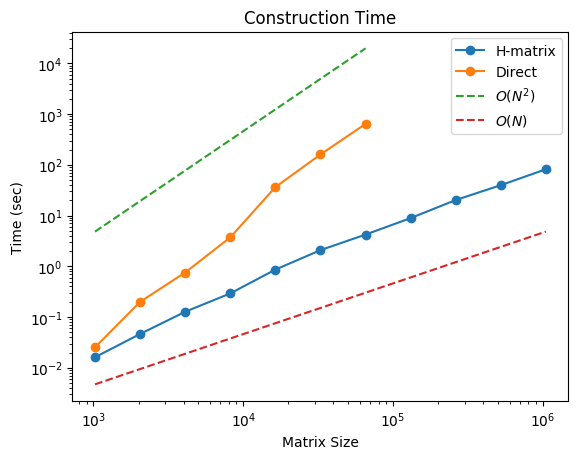

PyObject <matplotlib.legend.Legend object at 0x7f787aadac50>

In [241]:
loglog(2 .^(10:20), [x[1] for x in T], "o-", label="H-matrix")
loglog(2 .^(10:16), [x[1] for x in T1], "o-", label="Direct")


r = polyfit(log.(2 .^(10:20)), log.([x[1] for x in T]), 1)
r[1] = 2.0
loglog(2 .^(10:16), exp.(r(log.(2 .^(10:16)))), "--", label=L"O(N^2)")
r[1] = 1.0
loglog(2 .^(10:20), exp.(r(log.(2 .^(10:20)))), "--", label=L"O(N)")

xlabel("Matrix Size")
ylabel("Time (sec)")
title("Construction Time")
legend()

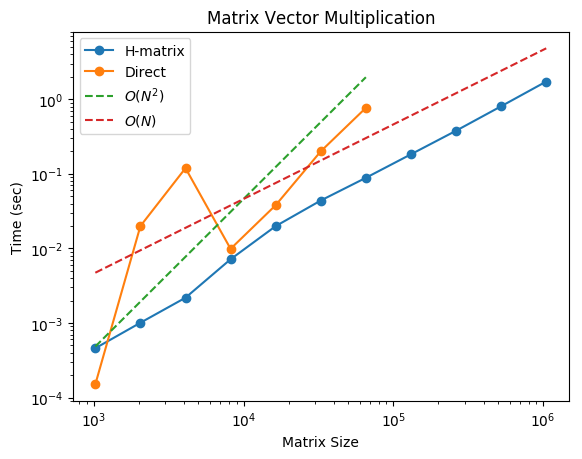

PyObject <matplotlib.legend.Legend object at 0x7f7725cf19b0>

In [246]:
loglog(2 .^(10:20), [x[2] for x in T], "o-", label="H-matrix")
loglog(2 .^(10:16), [x[2] for x in T1], "o-", label="Direct")

r = polyfit(log.(2 .^(10:20)), log.([x[1] for x in T]), 1)
r[1] = 2.0
loglog(2 .^(10:16), exp.(r(log.(2 .^(10:16))))./10000, "--", label=L"O(N^2)")
r[1] = 1.0
loglog(2 .^(10:20), exp.(r(log.(2 .^(10:20)))) , "--", label=L"O(N)")


xlabel("Matrix Size")
ylabel("Time (sec)")
title("Matrix Vector Multiplication")
legend()

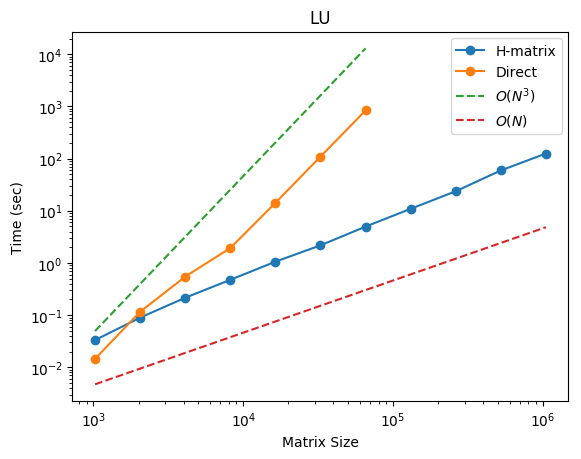

PyObject <matplotlib.legend.Legend object at 0x7f787a924ac8>

In [257]:
loglog(2 .^(10:20), [x[3] for x in T], "o-", label="H-matrix")
loglog(2 .^(10:16), [x[3] for x in T1], "o-", label="Direct")


r = polyfit(log.(2 .^(10:20)), log.([x[1] for x in T]), 1)
r[1] = 3.0
loglog(2 .^(10:16), exp.(r(log.(2 .^(10:16))))./100000, "--", label=L"O(N^3)")
r[1] = 1.0
loglog(2 .^(10:20), exp.(r(log.(2 .^(10:20)))) , "--", label=L"O(N)")



xlabel("Matrix Size")
ylabel("Time (sec)")
title("LU")
legend()

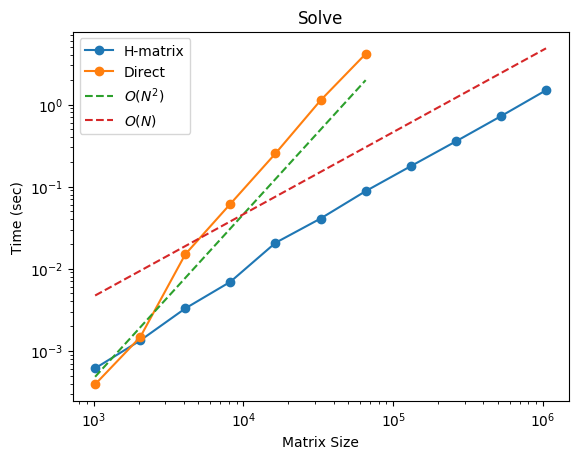

PyObject <matplotlib.legend.Legend object at 0x7f77249a7198>

In [256]:
loglog(2 .^(10:20), [x[4] for x in T], "o-", label="H-matrix")
loglog(2 .^(10:16), [x[4] for x in T1], "o-", label="Direct")

r = polyfit(log.(2 .^(10:20)), log.([x[1] for x in T]), 1)
r[1] = 2.0
loglog(2 .^(10:16), exp.(r(log.(2 .^(10:16))))./10000, "--", label=L"O(N^2)")
r[1] = 1.0
loglog(2 .^(10:20), exp.(r(log.(2 .^(10:20)))) , "--", label=L"O(N)")


xlabel("Matrix Size")
ylabel("Time (sec)")
title("Solve")
legend()

## Iterative Solver

In [187]:
function solution_from_dense(n=10, NT =100)
    N = 2^n
    cs = uniform_cluster(N, 64)
    h = 2/(N-1)
    X = h*collect(-2^(n-1):2^(n-1)-1)
    X = reshape(X, length(X), 1)
    c = cluster_from_list(cs, X);
    Δt = 1/NT
    C = sqrt(π)
    f, αs, βs = Merton_Kernel(5.0, 10)
    H = construct_hmat_from_expansion(f, αs, βs, c, 64, 2^(n-2))
    H1 = copy(H)
    H2 = copy(H)

    haxpy!(0.5*h, H1, -C/2+1/Δt)
    haxpy!(-0.5*h, H2, C/2+1/Δt)

    A = kernel_full(f, c.X, c.X)
    A1 = 0.5*h*A+(-C/2+1/Δt)*diagm(0=>ones(size(A,1))) # right
    A2 = -0.5*h*A+(C/2+1/Δt)*diagm(0=>ones(size(A,1))) # left 

    # iteration
    U1 = zeros(size(c.X,1), NT+1)
    U1[:,1] = exp.(-50 * c.X.^2)

    F = lu(A2)
    for i = 1:NT
        U1[:,i+1] = F\(A1*U1[:,i])
    end

    return c.X, U1[:,end]
end

solution_from_dense (generic function with 3 methods)

In [188]:
function solution_from_HH(n=10, NT=100)
    N = 2^n
    cs = uniform_cluster(N, 64)
    h = 2/(N-1)
    X = h*collect(-2^(n-1):2^(n-1)-1)
    X = reshape(X, length(X), 1)
    c = cluster_from_list(cs, X);

    Δt = 1/NT
    C = sqrt(π)
    f, αs, βs = Merton_Kernel(5.0, 10)
    H = construct_hmat_from_expansion(f, αs, βs, c, 64, 2^(n-2))
    H1 = copy(H)
    H2 = copy(H)


    haxpy!(0.5*h, H1, -C/2+1/Δt)
    haxpy!(-0.5*h, H2, C/2+1/Δt)


    HH = copy(H2)
    lu!(HH, 1e-2)

    # H matrix iteration
    U = zeros(size(c.X,1), NT+1)
    U[:,1] = exp.(-50 * c.X.^2)
    
    for i = 1:NT
        U[:,i+1] = pygmres(H2, H1*U[:,i], HH)
    end

    return c.X, U[:,end]
end

solution_from_HH (generic function with 3 methods)

In [190]:
Xref, Uref = solution_from_HH(13);

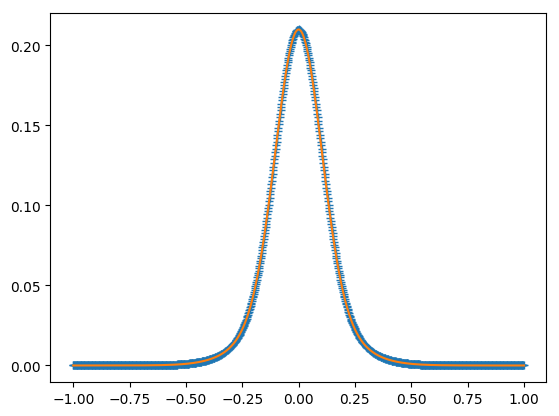

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f78af2c8d30>

In [191]:
Xres, Ures = solution_from_HH(10)
plot(Xres, Ures,"+")
plot(Xref, Uref)

In [194]:
_, Uref = solution_from_HH();
E = []
for NT = 10:10:50
    _, Ures = solution_from_HH(10, NT);
    err = pointwise_error(Uref, Ures)
    push!(E, err)
    println("$NT: $err")
end

10: 0.0006624088617109003
20: 0.00016033120467298656
30: 6.75272749546818e-5
40: 3.505866663983115e-5
50: 2.0032579160444985e-5


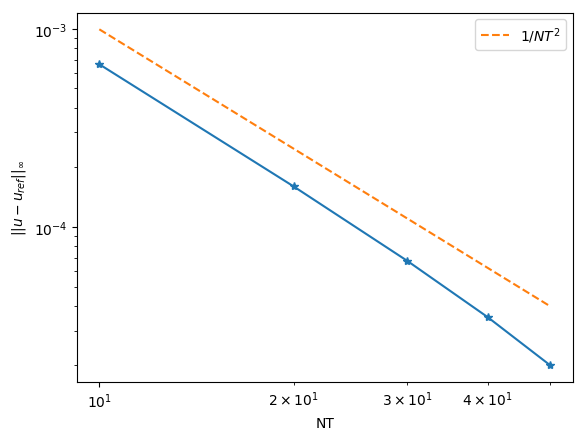

PyObject <matplotlib.legend.Legend object at 0x7f788048d7f0>

In [218]:
loglog(10:10:50, E, "*-")
r = polyfit(log.(10:10:50), log.(E), 1)
r[1] = -2.0
plot(10:50, exp.(r(log.(10:50))), "--", label=L"1/NT^2")
xlabel("NT")
ylabel(L"||u-u_{ref}||_\infty")
legend()

In [221]:
_, Uref = solution_from_HH(15, 10000);
E = []
for n = 10:14
    _, Ures = solution_from_HH(n, 10000);
    err = pointwise_error(Uref, Ures)
    push!(E, err)
    println("$NT: $err")
end

DimensionMismatch: DimensionMismatch("dimensions must match")